# Image generation with Stable Diffusion v3 and OpenVINO

Stable Diffusion V3 is next generation of latent diffusion image

## Prerequisites

In [1]:
%pip install -q "diffusers>=0.29.0" "gradio>=4.19" "torch>=2.1"  "transformers" "nncf>=2.11.0" "opencv-python" "pillow" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU --pre  "openvino" -extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly

## Build PyTorch pipeline

In [2]:
from pathlib import Path
import torch
from diffusers import StableDiffusion3Pipeline


MODEL_DIR = Path("stable-diffusion-3")
MODEL_DIR.mkdir(exist_ok=True)

TRANSFORMER_PATH = MODEL_DIR / "transformer.xml"
VAE_DECODER_PATH = MODEL_DIR / "vae_decoder.xml"
TEXT_ENCODER_PATH = MODEL_DIR / "text_encoder.xml"
TEXT_ENCODER_2_PATH = MODEL_DIR / "text_encoder_2.xml"
TEXT_ENCODER_3_PATH = MODEL_DIR / "text_encoder_3.xml"

requires_conversion = not all([TRANSFORMER_PATH.exists(), VAE_DECODER_PATH.exists(), TEXT_ENCODER_PATH.exists(), TEXT_ENCODER_2_PATH.exists(), TEXT_ENCODER_3_PATH.exists()])

transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = None, None, None, None, None

def get_pipeline_components():
    pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers")
    pipe.tokenizer.save_pretrained(MODEL_DIR / "tokenizer")
    pipe.tokenizer_2.save_pretrained(MODEL_DIR / "tokenizer_2")
    pipe.tokenizer_3.save_pretrained(MODEL_DIR / "tokenizer_3")
    pipe.scheduler.save_pretrained(MODEL_DIR / "scheduler")
    transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = None, None, None, None, None
    if not TRANSFORMER_PATH.exists():
        transformer = pipe.transformer
        transformer.eval()
    if not VAE_DECODER_PATH.exists():
        vae = pipe.vae
        vae.eval()
    if not TEXT_ENCODER_PATH.exists():
        text_encoder = pipe.text_encoder
        text_encoder.eval()
    if not TEXT_ENCODER_2_PATH.exists():
        text_encoder_2 = pipe.text_encoder_2
        text_encoder_2.eval()
    if not TEXT_ENCODER_3_PATH.exists():
        text_encoder_3 = pipe.text_encoder_3
        text_encoder_3.eval()
    return transformer, vae, text_encoder, text_encoder_2, text_encoder_3

if requires_conversion:
   transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = get_pipeline_components()

/home/ea/work/notebooks_env/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Convert and Optimize models with OpenVINO and NNCF
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

For reducing model memory consumption and improving performance we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

Let us convert and optimize each part:

### Transformer

In [3]:
import openvino as ov
from functools import partial
import gc

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

if not TRANSFORMER_PATH.exists():
    transformer.forward = partial(transformer.forward, return_dict=False)

    with torch.no_grad():
        ov_model = ov.convert_model(transformer, example_input={"hidden_states": torch.zeros((2, 16, 64, 64)), "timestep": torch.tensor([1, 1]), "encoder_hidden_states": torch.ones([2, 154, 4096]), "pooled_projections": torch.ones([2, 2048])})
    ov.save_model(ov_model, TRANSFORMER_PATH)
    del ov_model
    cleanup_torchscript_cache()

del transformer
gc.collect()

40

In [4]:
import ipywidgets as widgets

to_compress_weights = widgets.Checkbox(
    value=True,
    description="Weights Compression",
    disabled=False,
)

to_compress_weights

Checkbox(value=True, description='Weights Compression')

In [5]:
import nncf

core = ov.Core()

TRANSFORMER_INT4_PATH = MODEL_DIR / "transformer_int4.xml"

if to_compress_weights.value and not TRANSFORMER_INT4_PATH.exists():
    transformer = core.read_model(TRANSFORMER_PATH)
    compressed_transformer = nncf.compress_weights(transformer, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8, group_size=64)
    ov.save_model(compressed_transformer, TRANSFORMER_INT4_PATH)
    del compressed_transformer
    del transformer
    gc.collect()

if TRANSFORMER_INT4_PATH.exists():
    fp16_ir_model_size = TRANSFORMER_PATH.with_suffix(".bin").stat().st_size / 1024
    compressed_model_size = TRANSFORMER_INT4_PATH.with_suffix(".bin").stat().st_size / 1024

    print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
    print(f"INT8 model size: {compressed_model_size:.2f} KB")
    print(f"Model compression rate: {fp16_ir_model_size / compressed_model_size:.3f}")

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino
FP16 model size: 4072170.73 KB
INT8 model size: 1354828.03 KB
Model compression rate: 3.006


### T5 Text Encoder

In [6]:
if not TEXT_ENCODER_3_PATH.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(text_encoder_3, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_3_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder_3
gc.collect() 

11

In [7]:
to_compress_weights

Checkbox(value=True, description='Weights Compression')

In [8]:
TEXT_ENCODER_3_INT4_PATH = MODEL_DIR / "text_encoder_3_int4.xml"

if to_compress_weights.value and not TEXT_ENCODER_3_INT4_PATH.exists():
    encoder = core.read_model(TEXT_ENCODER_3_PATH)
    compressed_encoder = nncf.compress_weights(encoder, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8, group_size=64)
    ov.save_model(compressed_encoder, TEXT_ENCODER_3_INT4_PATH)
    del compressed_encoder
    del encoder
    gc.collect()

if TEXT_ENCODER_3_INT4_PATH.exists():
    fp16_ir_model_size = TEXT_ENCODER_3_PATH.with_suffix(".bin").stat().st_size / 1024
    compressed_model_size = TEXT_ENCODER_3_INT4_PATH.with_suffix(".bin").stat().st_size / 1024

    print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
    print(f"INT8 model size: {compressed_model_size:.2f} KB")
    print(f"Model compression rate: {fp16_ir_model_size / compressed_model_size:.3f}")

FP16 model size: 11267468.25 KB
INT8 model size: 3120896.53 KB
Model compression rate: 3.610


### Clip text encoders

In [9]:
if not TEXT_ENCODER_PATH.exists():
    with torch.no_grad():
        text_encoder.forward = partial(text_encoder.forward, output_hidden_states=True, return_dict=False)
        ov_model = ov.convert_model(text_encoder, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder
gc.collect() 

0

In [10]:
if not TEXT_ENCODER_2_PATH.exists():
    with torch.no_grad():
        text_encoder_2.forward = partial(text_encoder_2.forward, output_hidden_states=True, return_dict=False)
        ov_model = ov.convert_model(text_encoder_2, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_2_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder_2
gc.collect()

0

### VAE

In [11]:
if not VAE_DECODER_PATH.exists():
    with torch.no_grad():
        vae.forward = vae.decode
        ov_model = ov.convert_model(vae, example_input=torch.ones([1, 16, 64, 64]))
    ov.save_model(ov_model, VAE_DECODER_PATH)

del vae
gc.collect()

0

## Prepare OpenVINO infernce pipeline

In [12]:
encoderimport inspect
from typing import Any, Callable, Dict, List, Optional, Union

import torch
from transformers import (
    CLIPTextModelWithProjection,
    CLIPTokenizer,
    T5EncoderModel,
    T5TokenizerFast,
)

from diffusers.image_processor import VaeImageProcessor
from diffusers.models.autoencoders import AutoencoderKL
from diffusers.models.transformers import SD3Transformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from diffusers.utils import (
    logging,
)
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion_3.pipeline_output import StableDiffusion3PipelineOutput


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    """
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):encoder
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps


class OVStableDiffusion3Pipeline(DiffusionPipeline):
    r"""
    Args:
        transformer ([`SD3Transformer2DModel`]):
            Conditional Transformer (MMDiT) architecture to denoise the encoded image latents.
        scheduler ([`FlowMatchEulerDiscreteScheduler`]):
            A scheduler to be used in combination with `transformer` to denoise the encoded image latents.
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModelWithProjection`]):
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModelWithProjection),
            specifically the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant,
            with an additional added projection layer that is initialized with a diagonal matrix with the `hidden_size`
            as its dimension.
        text_encoder_2 ([`CLIPTextModelWithProjection`]):
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModelWithProjection),
            specifically the
            [laion/CLIP-ViT-bigG-14-laion2B-39B-b160k](https://huggingface.co/laion/CLIP-ViT-bigG-14-laion2B-39B-b160k)
            variant.
        text_encoder_3 ([`T5EncoderModel`]):
            Frozen text-encoder. Stable Diffusion 3 uses
            [T5](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5EncoderModel), specifically the
            [t5-v1_1-xxl](https://huggingface.co/google/t5-v1_1-xxl) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_2 (`CLIPTokenizer`):
            Second Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_3 (`T5TokenizerFast`):
            Tokenizer of class
            [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer).
    """
    _optional_components = []
    _callback_tensor_inputs = ["latents", "prompt_embeds", "negative_prompt_embeds", "negative_pooled_prompt_embeds"]

    def __init__(
        self,
        transformer: SD3Transformer2DModel,
        scheduler: FlowMatchEulerDiscreteScheduler,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModelWithProjection,
        tokenizer: CLIPTokenizer,
        text_encoder_2: CLIPTextModelWithProjection,
        tokenizer_2: CLIPTokenizer,
        text_encoder_3: T5EncoderModel,
        tokenizer_3: T5TokenizerFast,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            text_encoder_2=text_encoder_2,
            text_encoder_3=text_encoder_3,
            tokenizer=tokenizer,
            tokenizer_2=tokenizer_2,
            tokenizer_3=tokenizer_3,
            transformer=transformer,
            scheduler=scheduler,
        )
        self.vae_scale_factor = (
            2 ** 3
        )
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.tokenizer_max_length = (
            self.tokenizer.model_max_length if hasattr(self, "tokenizer") and self.tokenizer is not None else 77
        )
        self.vae_scaling_factor = 1.5305
        self.vae_shift_factor = 0.0609
        self.default_sample_size = 64

    def _get_t5_prompt_embeds(
        self,
        prompt: Union[str, List[str]] = None,
        num_images_per_prompt: int = 1,
    ):

        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        if self.text_encoder_3 is None:
            return torch.zeros(
                (batch_size, self.tokenizer_max_length, 4096),
            )

        text_inputs = self.tokenizer_3(
            prompt,
            padding="max_length",
            max_length=self.tokenizer_max_length,
            truncation=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = torch.from_numpy(self.text_encoder_3(text_input_ids)[0])
        _, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds

    def _get_clip_prompt_embeds(
        self,
        prompt: Union[str, List[str]],
        num_images_per_prompt: int = 1,
        clip_skip: Optional[int] = None,
        clip_model_index: int = 0,
    ):

        clip_tokenizers = [self.tokenizer, self.tokenizer_2]
        clip_text_encoders = [self.text_encoder, self.text_encoder_2]

        tokenizer = clip_tokenizers[clip_model_index]
        text_encoder = clip_text_encoders[clip_model_index]

        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer_max_length,
            truncation=True,
            return_tensors="pt")

        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids)
        pooled_prompt_embeds = torch.from_numpy(prompt_embeds[0])
        hidden_states = list(prompt_embeds.values())[1:]

        if clip_skip is None:
            prompt_embeds = torch.from_numpy(hidden_states[-2])
        else:
            prompt_embeds = torch.from_numpy(hidden_states[-(clip_skip + 2)])

        _, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt, 1)
        pooled_prompt_embeds = pooled_prompt_embeds.view(batch_size * num_images_per_prompt, -1)

        return prompt_embeds, pooled_prompt_embeds

    def encode_prompt(
            self,
            prompt: Union[str, List[str]],
            prompt_2: Union[str, List[str]],
            prompt_3: Union[str, List[str]],
            num_images_per_prompt: int = 1,
            do_classifier_free_guidance: bool = True,
            negative_prompt: Optional[Union[str, List[str]]] = None,
            negative_prompt_2: Optional[Union[str, List[str]]] = None,
            negative_prompt_3: Optional[Union[str, List[str]]] = None,
            prompt_embeds: Optional[torch.FloatTensor] = None,
            negative_prompt_embeds: Optional[torch.FloatTensor] = None,
            pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
            negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
            clip_skip: Optional[int] = None,
    ):

        prompt = [prompt] if isinstance(prompt, str) else prompt
        if prompt is not None:
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2

            prompt_3 = prompt_3 or prompt
            prompt_3 = [prompt_3] if isinstance(prompt_3, str) else prompt_3

            prompt_embed, pooled_prompt_embed = self._get_clip_prompt_embeds(
                prompt=prompt,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=clip_skip,
                clip_model_index=0,)
            prompt_2_embed, pooled_prompt_2_embed = self._get_clip_prompt_embeds(
                prompt=prompt_2,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=clip_skip,
                clip_model_index=1,)
            clip_prompt_embeds = torch.cat([prompt_embed, prompt_2_embed], dim=-1)

            t5_prompt_embed = self._get_t5_prompt_embeds(
                prompt=prompt_3,
                num_images_per_prompt=num_images_per_prompt,)

            clip_prompt_embeds = torch.nn.functional.pad(
                clip_prompt_embeds, (0, t5_prompt_embed.shape[-1] - clip_prompt_embeds.shape[-1]))

            prompt_embeds = torch.cat([clip_prompt_embeds, t5_prompt_embed], dim=-2)
            pooled_prompt_embeds = torch.cat([pooled_prompt_embed, pooled_prompt_2_embed], dim=-1)

        if do_classifier_free_guidance and negative_prompt_embeds is None:
            negative_prompt = negative_prompt or ""
            negative_prompt_2 = negative_prompt_2 or negative_prompt
            negative_prompt_3 = negative_prompt_3 or negative_prompt

            # normalize str to list
            negative_prompt = batch_size * [negative_prompt] if isinstance(negative_prompt, str) else negative_prompt
            negative_prompt_2 = (
                batch_size * [negative_prompt_2] if isinstance(negative_prompt_2, str) else negative_prompt_2)
            negative_prompt_3 = (
                batch_size * [negative_prompt_3] if isinstance(negative_prompt_3, str) else negative_prompt_3)

            if prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}.")
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`.")

            negative_prompt_embed, negative_pooled_prompt_embed = self._get_clip_prompt_embeds(
                negative_prompt,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=None,
                clip_model_index=0,)
            negative_prompt_2_embed, negative_pooled_prompt_2_embed = self._get_clip_prompt_embeds(
                negative_prompt_2,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=None,
                clip_model_index=1,)
            negative_clip_prompt_embeds = torch.cat([negative_prompt_embed, negative_prompt_2_embed], dim=-1)

            t5_negative_prompt_embed = self._get_t5_prompt_embeds(prompt=negative_prompt_3, num_images_per_prompt=num_images_per_prompt)

            negative_clip_prompt_embeds = torch.nn.functional.pad(
                negative_clip_prompt_embeds,
                (0, t5_negative_prompt_embed.shape[-1] - negative_clip_prompt_embeds.shape[-1]),
                )

            negative_prompt_embeds = torch.cat([negative_clip_prompt_embeds, t5_negative_prompt_embed], dim=-2)
            negative_pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embed, negative_pooled_prompt_2_embed], dim=-1)

        return prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds
    
    def check_inputs(self, prompt, prompt_2, prompt_3, height, width, negative_prompt=None, negative_prompt_2=None, negative_prompt_3=None, prompt_embeds=None, negative_prompt_embeds=None, pooled_prompt_embeds=None, negative_pooled_prompt_embeds=None, callback_on_step_end_tensor_inputs=None):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if callback_on_step_end_tensor_inputs is not None and not all(k in self._callback_tensor_inputs for k in callback_on_step_end_tensor_inputs):
            raise ValueError(
                f"`callback_on_step_end_tensor_inputs` has to be in {self._callback_tensor_inputs}, but found {[k for k in callback_on_step_end_tensor_inputs if k not in self._callback_tensor_inputs]}")

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two.")
        elif prompt_2 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_2`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two.")
        elif prompt_3 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_3`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two.")
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined.")
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")
        elif prompt_2 is not None and (not isinstance(prompt_2, str) and not isinstance(prompt_2, list)):
            raise ValueError(f"`prompt_2` has to be of type `str` or `list` but is {type(prompt_2)}")
        elif prompt_3 is not None and (not isinstance(prompt_3, str) and not isinstance(prompt_3, list)):
            raise ValueError(f"`prompt_3` has to be of type `str` or `list` but is {type(prompt_3)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two.")
        elif negative_prompt_2 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_2`: {negative_prompt_2} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two.")
        elif negative_prompt_3 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_3`: {negative_prompt_3} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two.")

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}.")

        if prompt_embeds is not None and pooled_prompt_embeds is None:
            raise ValueError(
                "If `prompt_embeds` are provided, `pooled_prompt_embeds` also have to be passed. Make sure to generate `pooled_prompt_embeds` from the same text encoder that was used to generate `prompt_embeds`.")

        if negative_prompt_embeds is not None and negative_pooled_prompt_embeds is None:
            raise ValueError(
                "If `negative_prompt_embeds` are provided, `negative_pooled_prompt_embeds` also have to be passed. Make sure to generate `negative_pooled_prompt_embeds` from the same text encoder that was used to generate `negative_prompt_embeds`.")

    def prepare_latents(self, batch_size, num_channels_latents, height, width, generator, latents=None):
        if latents is not None:
            return latents

        shape = (batch_size, num_channels_latents, int(height) // self.vae_scale_factor, int(width) // self.vae_scale_factor)

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators.")

        latents = randn_tensor(shape, generator=generator, device=torch.device("cpu"), dtype=torch.float32)

        return latents

    @property
    def guidance_scale(self):
        return self._guidance_scale

    @property
    def clip_skip(self):
        return self._clip_skip

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    @property
    def do_classifier_free_guidance(self):
        return self._guidance_scale > 1

    @property
    def joint_attention_kwargs(self):
        return self._joint_attention_kwargs

    @property
    def num_timesteps(self):
        return self._num_timesteps

    @property
    def interrupt(self):
        return self._interrupt

    @torch.no_grad()
    def __call__(self, prompt: Union[str, List[str]] = None, prompt_2: Optional[Union[str, List[str]]] = None, prompt_3: Optional[Union[str, List[str]]] = None, height: Optional[int] = None, width: Optional[int] = None, num_inference_steps: int = 28, timesteps: List[int] = None, guidance_scale: float = 7.0, negative_prompt: Optional[Union[str, List[str]]] = None, negative_prompt_2: Optional[Union[str, List[str]]] = None, negative_prompt_3: Optional[Union[str, List[str]]] = None, num_images_per_prompt: Optional[int] = 1,
                 generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
                 latents: Optional[torch.FloatTensor] = None, prompt_embeds: Optional[torch.FloatTensor] = None, negative_prompt_embeds: Optional[torch.FloatTensor] = None,
                 pooled_prompt_embeds: Optional[torch.FloatTensor] = None, negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
                 output_type: Optional[str] = "pil", return_dict: bool = True, clip_skip: Optional[int] = None, callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None, callback_on_step_end_tensor_inputs: List[str] = ["latents"]):

        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, prompt_2, prompt_3, height, width,
                          negative_prompt=negative_prompt, negative_prompt_2=negative_prompt_2,
                          negative_prompt_3=negative_prompt_3, prompt_embeds=prompt_embeds,
                          negative_prompt_embeds=negative_prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds,
                          negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
                          callback_on_step_end_tensor_inputs=callback_on_step_end_tensor_inputs)

        self._guidance_scale = guidance_scale
        self._clip_skip = clip_skip
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        results = self.encode_prompt(prompt=prompt, prompt_2=prompt_2, prompt_3=prompt_3,
                                     negative_prompt=negative_prompt, negative_prompt_2=negative_prompt_2,
                                     negative_prompt_3=negative_prompt_3,
                                     do_classifier_free_guidance=self.do_classifier_free_guidance,
                                     prompt_embeds=prompt_embeds,
                                     negative_prompt_embeds=negative_prompt_embeds,
                                     pooled_prompt_embeds=pooled_prompt_embeds,
                                     negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
                                     clip_skip=self.clip_skip, num_images_per_prompt=num_images_per_prompt)
        
        (prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds) = results

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embeds, pooled_prompt_embeds], dim=0)

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(self.scheduler, num_inference_steps, timesteps)
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)
        self._num_timesteps = len(timesteps)

        # 5. Prepare latent variables
        num_channels_latents = 16
        latents = self.prepare_latents(batch_size * num_images_per_prompt, num_channels_latents, height, width, generator, latents)

        # 6. Denoising loop
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
                timestep = t.expand(latent_model_input.shape[0])

                noise_pred = self.transformer([latent_model_input, prompt_embeds, pooled_prompt_embeds, timestep])[0]

                noise_pred = torch.from_numpy(noise_pred)

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)
                    negative_pooled_prompt_embeds = callback_outputs.pop("negative_pooled_prompt_embeds", negative_pooled_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        if output_type == "latent":
            image = latents

        else:
            latents = (latents / self.vae_scaling_factor) + self.vae_shift_factor

            image = torch.from_numpy(self.vae(latents)[0])
            image = self.image_processor.postprocess(image, output_type=output_type)

        if not return_dict:
            return (image,)

        return StableDiffusion3PipelineOutput(images=image)

## Run OpenVINO model

In [14]:
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

In [15]:
use_int4_transformer = widgets.Checkbox(
    value=TRANSFORMER_INT4_PATH.exists(),
    description="INT4 transformer",
    disabled=not TRANSFORMER_INT4_PATH.exists()
)

use_int4_t5 = widgets.Checkbox(
    value=TEXT_ENCODER_3_INT4_PATH.exists(),
    description="INT4 t5 text encoder",
    disabled=not TEXT_ENCODER_3_INT4_PATH.exists())

v_box_widgets = []
if TRANSFORMER_INT4_PATH.exists():
    v_box_widgets.append(use_int4_transformer)

if TEXT_ENCODER_3_INT4_PATH.exists():
    v_box_widgets.append(use_int4_t5)

if v_box_widgets:
    model_options = widgets.VBox(v_box_widgets)
    display(model_options)

In [16]:
ov_config = {}
if "GPU" in device.value:
    ov_config["INFERENCE_PRECISION_HINT"] = "f32"

transformer = core.compile_model(TRANSFORMER_PATH if not use_int4_transformer.value else TRANSFORMER_INT4_PATH, device.value)
text_encoder_3 = core.compile_model(TEXT_ENCODER_3_PATH if not use_int4_t5.value else TEXT_ENCODER_3_INT4_PATH, device.value, ov_config)
text_encoder = core.compile_model(TEXT_ENCODER_PATH, device.value, ov_config)
text_encoder_2 = core.compile_model(TEXT_ENCODER_2_PATH, device.value, ov_config)
vae = core.compile_model(VAE_DECODER_PATH, device.value)

In [17]:
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoTokenizer

scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(MODEL_DIR / "scheduler")

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer")
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer_2")
tokenizer_3 = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer_3")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [18]:
ov_pipe = OVStableDiffusion3Pipeline(transformer, scheduler, vae, text_encoder, tokenizer, text_encoder_2, tokenizer_2, text_encoder_3, tokenizer_3)

  0%|          | 0/28 [00:00<?, ?steps/s]

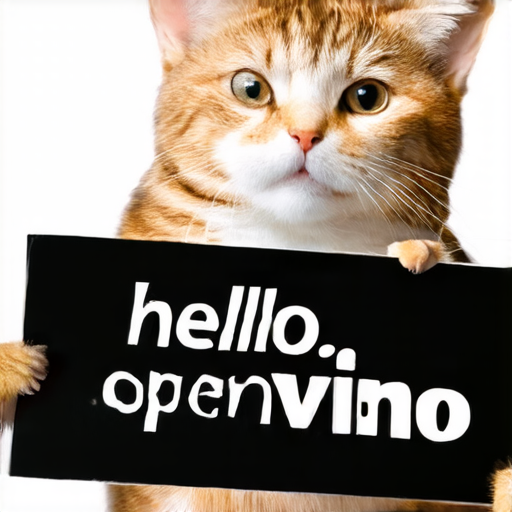

In [24]:
image = ov_pipe(
    "A cat holding a sign that says 'hello openvino'",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=5,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(141)
).images[0]
image

## Interactive demo

In [ ]:
import gradio as gr
import numpy as np
import random

MAX_SEED = np.iinfo(np.int32).max
MAX_IMAGE_SIZE = 1344

def infer(prompt, negative_prompt, seed, randomize_seed, width, height, guidance_scale, num_inference_steps, progress=gr.Progress(track_tqdm=True)):

    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
        
    generator = torch.Generator().manual_seed(seed)
    
    image = ov_pipe(
        prompt = prompt, 
        negative_prompt = negative_prompt,
        guidance_scale = guidance_scale, 
        num_inference_steps = num_inference_steps, 
        width = width, 
        height = height,
        generator = generator
    ).images[0]
    
    return image, seed

examples = [
    "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "An astronaut riding a green horse",
    "A delicious ceviche cheesecake slice",
]

css="""
#col-container {
    margin: 0 auto;
    max-width: 580px;
}
"""

with gr.Blocks(css=css) as demo:
    
    with gr.Column(elem_id="col-container"):
        gr.Markdown(f"""
        # Demo [Stable Diffusion 3 Medium](https://huggingface.co/stabilityai/stable-diffusion-3-medium) with OpenVINO
        """)
        
        with gr.Row():
            
            prompt = gr.Text(
                label="Prompt",
                show_label=False,
                max_lines=1,
                placeholder="Enter your prompt",
                container=False,
            )
            
            run_button = gr.Button("Run", scale=0)
        
        result = gr.Image(label="Result", show_label=False)

        with gr.Accordion("Advanced Settings", open=False):
            
            negative_prompt = gr.Text(
                label="Negative prompt",
                max_lines=1,
                placeholder="Enter a negative prompt",
            )
            
            seed = gr.Slider(
                label="Seed",
                minimum=0,
                maximum=MAX_SEED,
                step=1,
                value=0,
            )
            
            randomize_seed = gr.Checkbox(label="Randomize seed", value=True)
            
            with gr.Row():
                
                width = gr.Slider(
                    label="Width",
                    minimum=256,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=512,
                )
                
                height = gr.Slider(
                    label="Height",
                    minimum=256,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=512,
                )
            
            with gr.Row():
                
                guidance_scale = gr.Slider(
                    label="Guidance scale",
                    minimum=0.0,
                    maximum=10.0,
                    step=0.1,
                    value=5.0,
                )
                
                num_inference_steps = gr.Slider(
                    label="Number of inference steps",
                    minimum=1,
                    maximum=50,
                    step=1,
                    value=28,
                )
        
        gr.Examples(
            examples = examples,
            inputs = [prompt]
        )
    gr.on(
        triggers=[run_button.click, prompt.submit, negative_prompt.submit],
        fn = infer,
        inputs = [prompt, negative_prompt, seed, randomize_seed, width, height, guidance_scale, num_inference_steps],
        outputs = [result, seed]
    )

demo.launch()